In [59]:
import sys
sys.path.append('../..')

import pandas as pd
import ccxt
import numpy as np
import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

import matplotlib.pyplot as plt

from Downloads.backtest_tools.utilities.backtesting import basic_single_asset_backtest, plot_wallet_vs_asset, get_metrics, get_n_columns, plot_sharpe_evolution, plot_bar_by_month
from Downloads.backtest_tools.utilities.get_data import get_historical_from_db
import ta


In [60]:
"""pair = "ADA/USDT"
tf = "1d"

df = get_historical_from_db(
    ccxt.binance(), 
    pair,
    tf,
    path="../../database/"
)

training_set = df.copy().loc[:"2020"]
test_set = df.copy().loc["2021":]
learn_period = 7

training_set"""
pair = "SOLUSD2H"

In [61]:
df = pd.read_csv('C:/Users/ETOUNDI/Downloads/FETUSD2H.csv')
df=df.iloc[::-1].reset_index(drop=True)
# Supprime les colonnes inutiles
df.drop(columns = df.columns.difference(['timestamp','open','high','low','close']), inplace=True)
# Convertit les dates dans un format lisible
df['timestamp'] = pd.to_datetime(df['timestamp']) 
df = df.set_index("timestamp", drop=True)
df

,open,close,high,low
timestamp,,,,
2021-01-01 00:00:00,0.051776,0.053694,0.053794,0.051263
2021-01-01 04:00:00,0.053584,0.053053,0.053654,0.052269
2021-01-01 08:00:00,0.053118,0.053475,0.053765,0.052308
2021-01-01 12:00:00,0.053619,0.054535,0.055915,0.053194
2021-01-01 16:00:00,0.055095,0.052980,0.055802,0.052573
...,...,...,...,...
2024-10-22 00:00:00,1.390100,1.391500,1.413500,1.375100
2024-10-22 04:00:00,1.386000,1.393500,1.406700,1.375500
2024-10-22 08:00:00,1.391300,1.366100,1.391300,1.352200


In [62]:
training_set = df.copy().loc[:"2023"]
test_set = df.copy().loc["2024":]
learn_period = 7

training_set

,open,close,high,low
timestamp,,,,
2021-01-01 00:00:00,0.051776,0.053694,0.053794,0.051263
2021-01-01 04:00:00,0.053584,0.053053,0.053654,0.052269
2021-01-01 08:00:00,0.053118,0.053475,0.053765,0.052308
2021-01-01 12:00:00,0.053619,0.054535,0.055915,0.053194
2021-01-01 16:00:00,0.055095,0.052980,0.055802,0.052573
...,...,...,...,...
2023-12-31 04:00:00,0.691580,0.701680,0.702110,0.691580
2023-12-31 08:00:00,0.700950,0.699150,0.705670,0.695150
2023-12-31 12:00:00,0.698070,0.694080,0.706820,0.693700


In [63]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set["close"].values.reshape(-1, 1))

X_train = []
y_train = []

for i in range(learn_period, len(training_set)):
    X_train.append(training_set_scaled[i-learn_period:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train[0][0:2]

array([[0.00273545],
       [0.00213578]])

In [64]:
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
205/205 [==============================] - 24s 26ms/step - loss: 0.0085
Epoch 2/50
205/205 [==============================] - 6s 27ms/step - loss: 0.0016
Epoch 3/50
205/205 [==============================] - 7s 33ms/step - loss: 0.0015
Epoch 4/50
205/205 [==============================] - 7s 34ms/step - loss: 0.0014
Epoch 5/50
205/205 [==============================] - 7s 34ms/step - loss: 0.0013
Epoch 6/50
205/205 [==============================] - 7s 34ms/step - loss: 0.0013
Epoch 7/50
205/205 [==============================] - 7s 35ms/step - loss: 0.0013
Epoch 8/50
205/205 [==============================] - 7s 34ms/step - loss: 0.0012
Epoch 9/50
205/205 [==============================] - 7s 34ms/step - loss: 0.0011
Epoch 10/50
205/205 [==============================] - 7s 33ms/step - loss: 0.0011
Epoch 11/50
205/205 [==============================] - 7s 34ms/step - loss: 0.0010
Epoch 12/50
205/205 [==============================] - 6s 31ms/step - loss: 9.0593e-04
Epoch 13

In [65]:
real_stock_price = test_set.iloc[:, 1:2].values

dataset_total = pd.concat((training_set['close'], test_set['close']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test_set) - learn_period:].values
inputs = inputs.reshape(-1,1)
inputs = sc.fit_transform(inputs)
X_test = []
for i in range(learn_period, len(test_set) + learn_period):
    X_test.append(inputs[i-learn_period:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

56/56 [==============================] - 4s 10ms/step


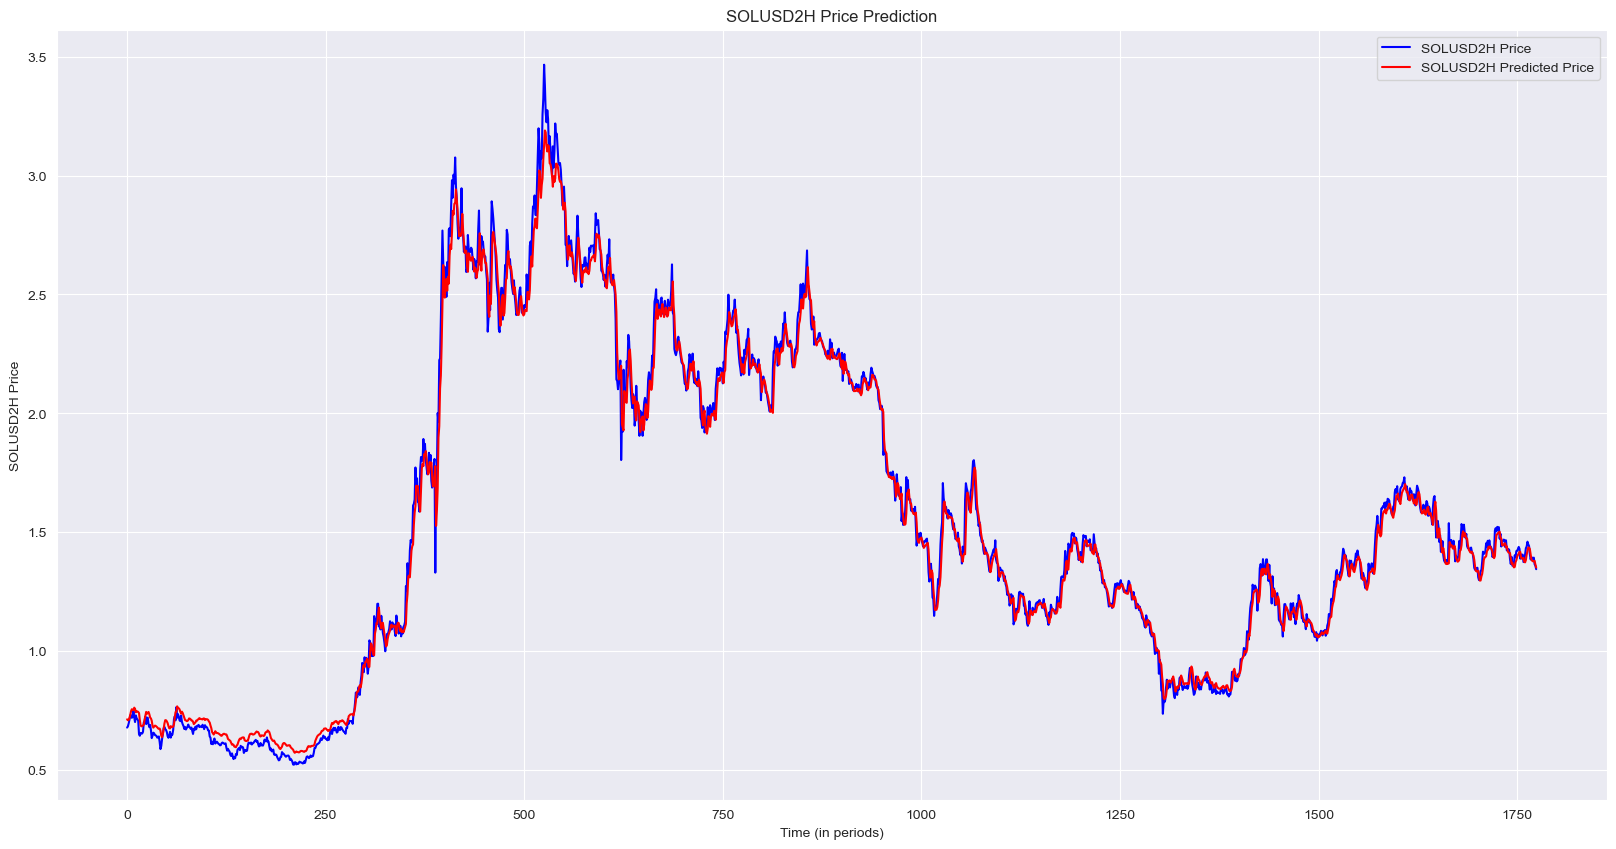

In [66]:
plt.figure(figsize=(20,10))
plt.plot(real_stock_price, color = 'blue', label = pair + ' Price')
plt.plot(predicted_stock_price, color = 'red', label = pair + ' Predicted Price')
plt.title(pair +' Price Prediction')
plt.xlabel('Time (in periods)')
plt.ylabel(pair + ' Price')
plt.legend()
plt.show()

In [67]:
df["predicted"] = 0
df["predicted"].iloc[-len(predicted_stock_price.flatten()):] = predicted_stock_price.flatten()
df["diff_close"] = df["close"].diff()
df["diff_predicted"] = df["predicted"].diff()
df["next_predicted"] = df["predicted"].shift(-1)
df["next_close"] = df["close"].shift(-1)
df["diff_predicted_next"] = df["next_predicted"] - df["predicted"]
df["diff_close_next"] = df["next_close"] - df["close"]
df["mean_evol_3"] = df["close"].shift(-3).rolling(3).mean() - df["close"]
df["mean_evol_5"] = df["close"].shift(-5).rolling(5).mean() - df["close"]
df["mean_evol_10"] = df["close"].shift(-10).rolling(10).mean() - df["close"]
df["mean_evol_20"] = df["close"].shift(-20).rolling(20).mean() - df["close"]
df

C:\Users\ETOUNDI\AppData\Local\Temp\ipykernel_16368\3246702837.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["predicted"].iloc[-len(predicted_stock_price.flatten()):] = predicted_stock_price.flatten()
C:\Users\ETOUNDI\AppData\Local\Temp\ipykernel_16368\3246702837.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.7136846  0.7096366  0.71158487 ... 1.3798828  1.364543   1.3520133 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df["predicted"].iloc[-len(predicted_stock_price.flatten()):] = predicted_stock_price.flatten()


,open,close,high,low,predicted,diff_close,diff_predicted,next_predicted,next_close,diff_predicted_next,diff_close_next,mean_evol_3,mean_evol_5,mean_evol_10,mean_evol_20
timestamp,,,,,,,,,,,,,,,
2021-01-01 00:00:00,0.051776,0.053694,0.053794,0.051263,0.000000,NaN,NaN,0.000000,0.053053,0.000000,-0.000641,NaN,NaN,NaN,NaN
2021-01-01 04:00:00,0.053584,0.053053,0.053654,0.052269,0.000000,-0.000641,0.000000,0.000000,0.053475,0.000000,0.000422,NaN,NaN,NaN,NaN
2021-01-01 08:00:00,0.053118,0.053475,0.053765,0.052308,0.000000,0.000422,0.000000,0.000000,0.054535,0.000000,0.001060,0.000102,NaN,NaN,NaN
2021-01-01 12:00:00,0.053619,0.054535,0.055915,0.053194,0.000000,0.001060,0.000000,0.000000,0.052980,0.000000,-0.001555,-0.001247,NaN,NaN,NaN
2021-01-01 16:00:00,0.055095,0.052980,0.055802,0.052573,0.000000,-0.001555,0.000000,0.000000,0.053217,0.000000,0.000237,0.000853,0.000275,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22 00:00:00,1.390100,1.391500,1.413500,1.375100,1.377881,0.003500,-0.002588,1.378629,1.393500,0.000748,0.002000,-0.018467,NaN,NaN,NaN
2024-10-22 04:00:00,1.386000,1.393500,1.406700,1.375500,1.378629,0.002000,0.000748,1.379883,1.366100,0.001254,-0.027400,-0.036600,NaN,NaN,NaN
2024-10-22 08:00:00,1.391300,1.366100,1.391300,1.352200,1.379883,-0.027400,0.001254,1.364543,1.359500,-0.015340,-0.006600,NaN,NaN,NaN,NaN


In [68]:
print(len(df.loc[(df["diff_predicted_next"] > df["diff_close"]) & (df["diff_close_next"] > 0)]))
print(len(df.loc[(df["diff_predicted_next"] > df["diff_close"]) & (df["diff_close_next"] < 0)]))
print("-------------")
print(len(df.loc[(df["diff_predicted_next"] < df["diff_close"]) & (df["diff_close_next"] < 0)]))
print(len(df.loc[(df["diff_predicted_next"] < df["diff_close"]) & (df["diff_close_next"] > 0)]))
print("-------------")
print(df.loc[(df["diff_predicted_next"] > df["diff_close"])]["diff_close_next"].mean())
print(df.loc[(df["diff_predicted_next"] > df["diff_close"])]["mean_evol_3"].mean())
print(df.loc[(df["diff_predicted_next"] > df["diff_close"])]["mean_evol_5"].mean())
print(df.loc[(df["diff_predicted_next"] > df["diff_close"])]["mean_evol_10"].mean())
print(df.loc[(df["diff_predicted_next"] > df["diff_close"])]["mean_evol_20"].mean())
print("-------------")
print(df.loc[(df["diff_predicted_next"] < df["diff_close"])]["diff_close_next"].mean())
print(df.loc[(df["diff_predicted_next"] < df["diff_close"])]["mean_evol_3"].mean())
print(df.loc[(df["diff_predicted_next"] < df["diff_close"])]["mean_evol_5"].mean())
print(df.loc[(df["diff_predicted_next"] < df["diff_close"])]["mean_evol_10"].mean())
print(df.loc[(df["diff_predicted_next"] < df["diff_close"])]["mean_evol_20"].mean())

2206
2016
-------------
2232
1865
-------------
0.0010590955534531697
0.0017702122574538705
0.002043261571225744
0.002682446884624497
0.003338162164728222
-------------
-0.0007788021951219516
-0.0011878007644140721
-0.0011342192429792425
-0.0009524785085574574
3.0351201569396517e-05


In [69]:
print(len(df.loc[(df["diff_predicted"] > 0) & (df["diff_close"] > 0)]))
print(len(df.loc[(df["diff_predicted"] > 0) & (df["diff_close"] < 0)]))
print("-------------")
print(len(df.loc[(df["diff_predicted"] < 0) & (df["diff_close"] < 0)]))
print(len(df.loc[(df["diff_predicted"] < 0) & (df["diff_close"] > 0)]))
print("-------------")
print(df.loc[(df["diff_predicted"] > 0)]["diff_close_next"].mean())
print(df.loc[(df["diff_predicted"] > 0)]["mean_evol_3"].mean())
print(df.loc[(df["diff_predicted"] > 0)]["mean_evol_5"].mean())
print(df.loc[(df["diff_predicted"] > 0)]["mean_evol_10"].mean())
print(df.loc[(df["diff_predicted"] > 0)]["mean_evol_20"].mean())
print("-------------")
print(df.loc[(df["diff_predicted"] < 0)]["diff_close_next"].mean())
print(df.loc[(df["diff_predicted"] < 0)]["mean_evol_3"].mean())
print(df.loc[(df["diff_predicted"] < 0)]["mean_evol_5"].mean())
print(df.loc[(df["diff_predicted"] < 0)]["mean_evol_10"].mean())
print(df.loc[(df["diff_predicted"] < 0)]["mean_evol_20"].mean())

382
457
-------------
460
474
-------------
-0.0006194040524433824
0.0006398170246620479
0.0015372759856630744
0.004674804062126649
0.01007276173285198
-------------
0.00126817112299465
0.0008748358315490513
0.0008319249732047184
-0.00010582219827586235
-0.0010819751082251023


In [70]:
class lstm_strat():
    def __init__(
        self,
        df,
        use_short=True,
        strat=0,
    ):
        self.df = df
        self.use_short = use_short
        self.strat = strat
        
    def populate_indicators(self, show_log=False):
        # -- Clear dataset --
        df = self.df
        df.drop(columns=df.columns.difference(['open','high','low','close','volume', "predicted"]), inplace=True)
        
        # -- Populate indicators --
        df["diff_close"] = df["close"].diff()
        df["diff_predicted"] = df["predicted"].diff()
        df["next_predicted"] = df["predicted"].shift(-1)
        df["diff_predicted_next"] = df["next_predicted"] - df["predicted"]
        
        # -- Log --
        if(show_log):
            print(df)
        
        self.df = df    
        return self.df
    
    def populate_buy_sell(self, show_log=False): 
        df = self.df
        # -- Initiate populate --
        df["open_long_market"] = False
        df["close_long_market"] = False
        df["open_short_market"] = False
        df["close_short_market"] = False
        
        if self.strat == 0:
            # -- Populate open long market --
            df.loc[
                (df['diff_predicted'] > 0)
                , "open_long_market"
            ] = True
            
            # -- Populate close long market --
            df.loc[
                (df['diff_predicted'] < 0) 
                , "close_long_market"
            ] = True
            
            if self.use_short:
                # -- Populate open short market --
                df.loc[
                    (df['diff_predicted'] < 0) 
                    , "open_short_market"
                ] = True
                
                # -- Populate close short market --
                df.loc[
                    (df['diff_predicted'] > 0) 
                    , "close_short_market"
                ] = True

        elif self.strat == 1:
            # -- Populate open long market --
            df.loc[
                (df['diff_predicted_next'] > df['diff_close'])
                , "open_long_market"
            ] = True
            
            # -- Populate close long market --
            df.loc[
                (df['diff_close'] > df['diff_predicted_next']) 
                , "close_long_market"
            ] = True
            
            if self.use_short:
                # -- Populate open short market --
                df.loc[
                    (df['diff_close'] > df['diff_predicted_next']) 
                    , "open_short_market"
                ] = True
                
                # -- Populate close short market --
                df.loc[
                    (df['diff_predicted_next'] > df['diff_close']) 
                    , "close_short_market"
                ] = True
            
        
        # -- Log --
        if(show_log):
            print("Open LONG length :",len(df.loc[df["open_long_market"]==True]))
            print("Close LONG length :",len(df.loc[df["close_long_market"]==True]))
            print("Open SHORT length :",len(df.loc[df["open_short_market"]==True]))
            print("Close SHORT length :",len(df.loc[df["close_short_market"]==True]))
        
        self.df = df   
        return self.df
        
    def run_backtest(self, initial_wallet=1000, return_type="metrics"):
        dt = self.df[:]
        wallet = initial_wallet
        maker_fee = 0
        taker_fee = 0.0007
        trades = []
        days = []
        current_day = 0
        previous_day = 0
        current_position = None

        # print("tp",take_profit_pct,"sl",stop_loss_pct)
        
        for index, row in dt.iterrows():
            
            # -- Add daily report --
            current_day = index.day
            if previous_day != current_day:
                temp_wallet = wallet
                if current_position:
                    if current_position['side'] == "LONG":
                        close_price = row['close']
                        trade_result = (close_price - current_position['price']) / current_position['price']
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    elif current_position['side'] == "SHORT":
                        close_price = row['close']
                        trade_result = (current_position['price'] - close_price) / current_position['price']
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    
                days.append({
                    "day":str(index.year)+"-"+str(index.month)+"-"+str(index.day),
                    "wallet":temp_wallet,
                    "price":row['close']
                })
            previous_day = current_day
            if current_position:
            # -- Check for closing position --
                if current_position['side'] == "LONG":
                        
                    # -- Close LONG market --
                    if row['close_long_market']:
                        close_price = row['close']
                        trade_result = (close_price - current_position['price']) / current_position['price']
                        wallet += wallet * trade_result
                        fee = wallet * taker_fee
                        wallet -= fee
                        trades.append({
                            "open_date": current_position['date'],
                            "close_date": index,
                            "position": "LONG",
                            "open_reason": current_position['reason'],
                            "close_reason": "Market",
                            "open_price": current_position['price'],
                            "close_price": close_price,
                            "open_fee": current_position['fee'],
                            "close_fee": fee,
                            "open_trade_size":current_position['size'],
                            "close_trade_size": wallet,
                            "wallet": wallet
                        })
                        current_position = None
                        
                elif current_position['side'] == "SHORT":
                    # -- Close SHORT Market --
                    if row['close_short_market']:
                        close_price = row['close']
                        trade_result = (current_position['price'] - close_price) / current_position['price']
                        wallet += wallet * trade_result
                        fee = wallet * taker_fee
                        wallet -= fee
                        trades.append({
                            "open_date": current_position['date'],
                            "close_date": index,
                            "position": "SHORT",
                            "open_reason": current_position['reason'],
                            "close_reason": "Market",
                            "open_price": current_position['price'],
                            "close_price": close_price,
                            "open_fee": current_position['fee'],
                            "close_fee": fee,
                            "open_trade_size": current_position['size'],
                            "close_trade_size": wallet,
                            "wallet": wallet
                        })
                        current_position = None

            # -- Check for opening position --
            else:
                # Open long market
                if row['open_long_market']:
                    open_price = row['close']
                    fee = wallet * taker_fee
                    wallet -= fee
                    pos_size = wallet
                    current_position = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Market",
                        "side": "LONG",
                    }
                elif row['open_short_market']:
                    open_price = row['close']
                    fee = wallet * taker_fee
                    wallet -= fee
                    pos_size = wallet
                    current_position = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Market",
                        "side": "SHORT"
                    }
                    
                    
        df_days = pd.DataFrame(days)
        df_days['day'] = pd.to_datetime(df_days['day'])
        df_days = df_days.set_index(df_days['day'])

        df_trades = pd.DataFrame(trades)
        df_trades['open_date'] = pd.to_datetime(df_trades['open_date'])
        df_trades = df_trades.set_index(df_trades['open_date'])   
        
        if return_type == "metrics":
            return get_metrics(df_trades, df_days) | {
                "wallet": wallet,
                "trades": df_trades,
                "days": df_days
            }  
        else:
            return True    
        

Period: [2024-01-01 00:00:00] -> [2024-10-22 00:00:00]
Initial wallet: 1000.0 $

--- General Information ---
Final wallet: 274.64 $
Performance vs US dollar: -72.54 %
Sharpe Ratio: -0.71
Worst Drawdown T|D: -86.66% | -86.44%
Buy and hold performance: 104.92 %
Performance vs buy and hold: -86.6 %
Total trades on the period: 471
Global Win rate: 41.83 %
Average Profit: -0.16 %
Total fees paid 540.4$

Best trades: +43.34 % the 2024-03-06 00:00:00 -> 2024-03-07 12:00:00
Worst trades: -14.62 % the 2024-03-02 08:00:00 -> 2024-03-02 16:00:00


KeyError: 'drawdown_pct'

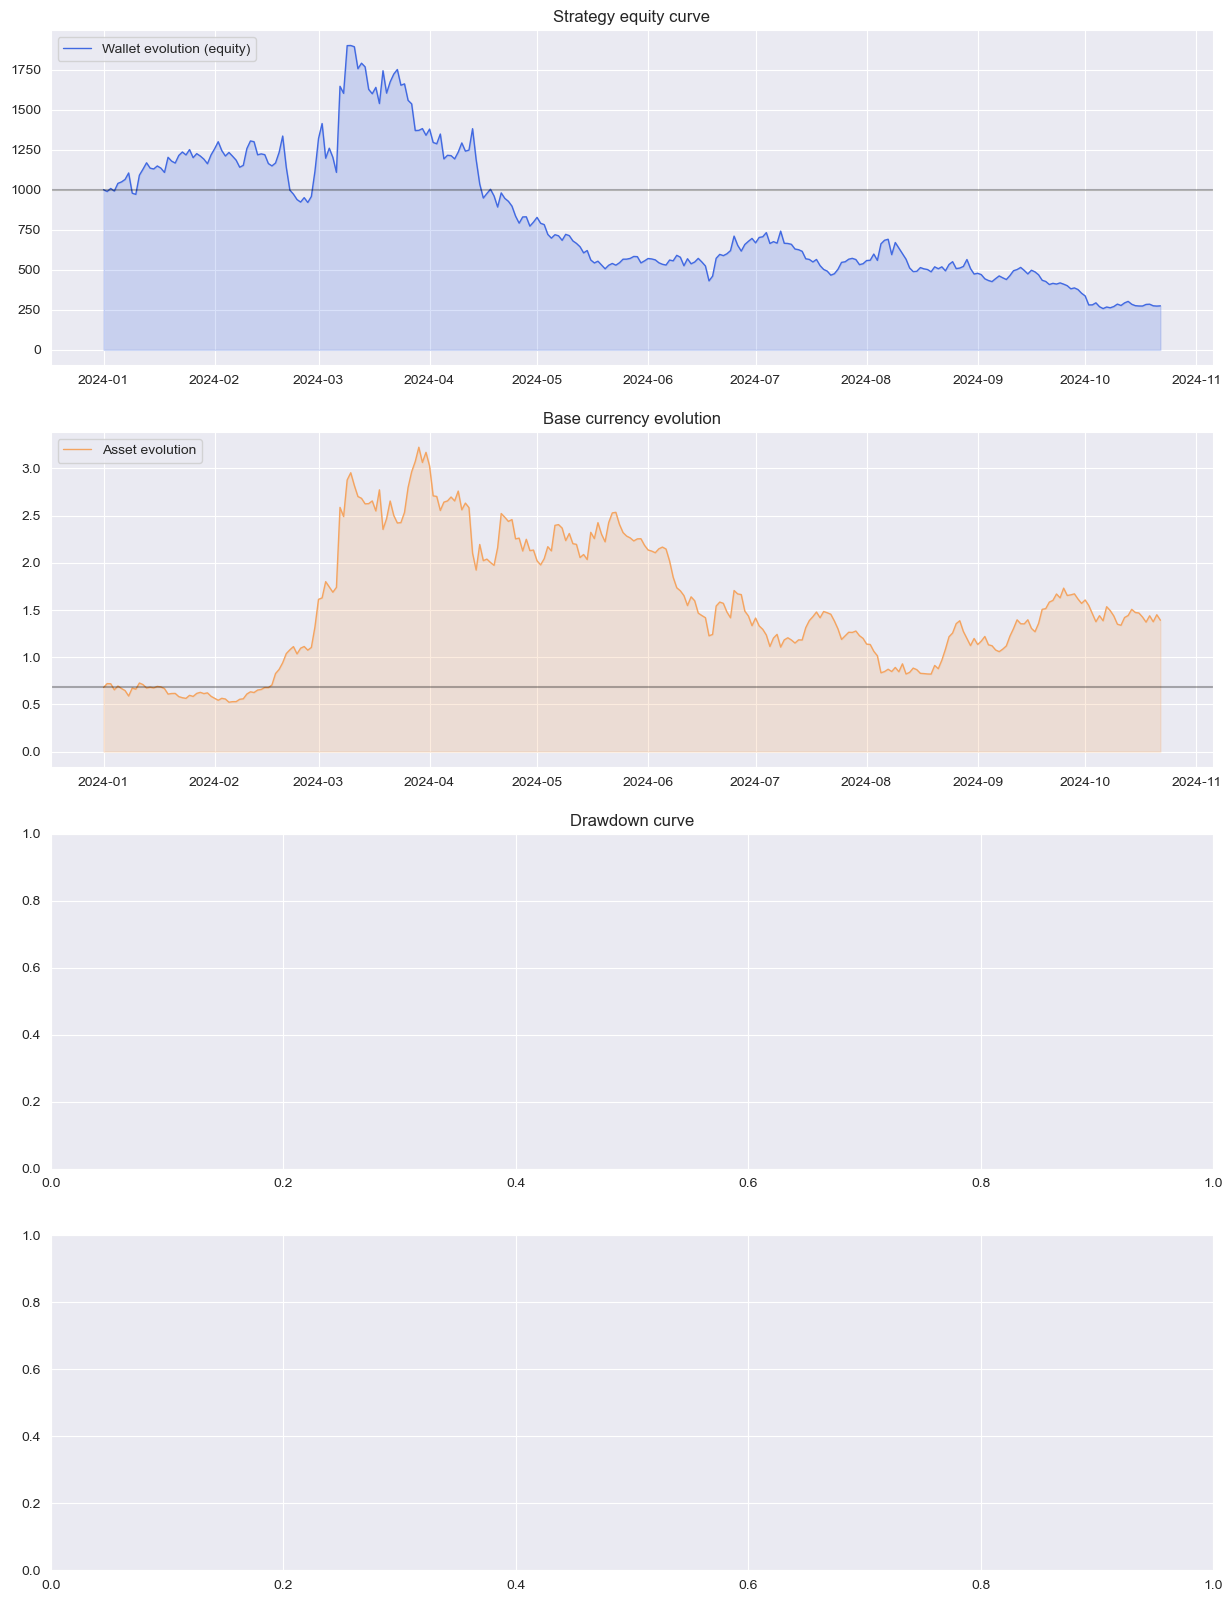

In [71]:
dt = df.copy().loc["2024":]

strat = lstm_strat(
    df = dt,
    use_short=True,
    strat=0,
)

strat.populate_indicators()
strat.populate_buy_sell(show_log=False)
bt_result = strat.run_backtest(initial_wallet=1000, return_type="metrics")
df_trades, df_days = basic_single_asset_backtest(trades=bt_result['trades'], days = bt_result['days'])
plot_wallet_vs_asset(df_days=bt_result['days'])

Open LONG length : 4228
Close LONG length : 4100
Open SHORT length : 0
Close SHORT length : 0
Period: [2021-01-01 00:00:00] -> [2024-10-22 00:00:00]
Initial wallet: 1000.0 $

--- General Information ---
Final wallet: 163488.9 $
Performance vs US dollar: 16248.89 %
Sharpe Ratio: 1.81
Worst Drawdown T|D: -71.25% | -71.45%
Buy and hold performance: 2491.54 %
Performance vs buy and hold: 530.86 %
Total trades on the period: 2316
Global Win rate: 62.05 %
Average Profit: 0.29 %
Total fees paid 222976.34$

Best trades: +23.4 % the 2021-09-07 20:00:00 -> 2021-09-08 00:00:00
Worst trades: -24.71 % the 2021-05-18 20:00:00 -> 2021-05-20 04:00:00


KeyError: 'drawdown_pct'

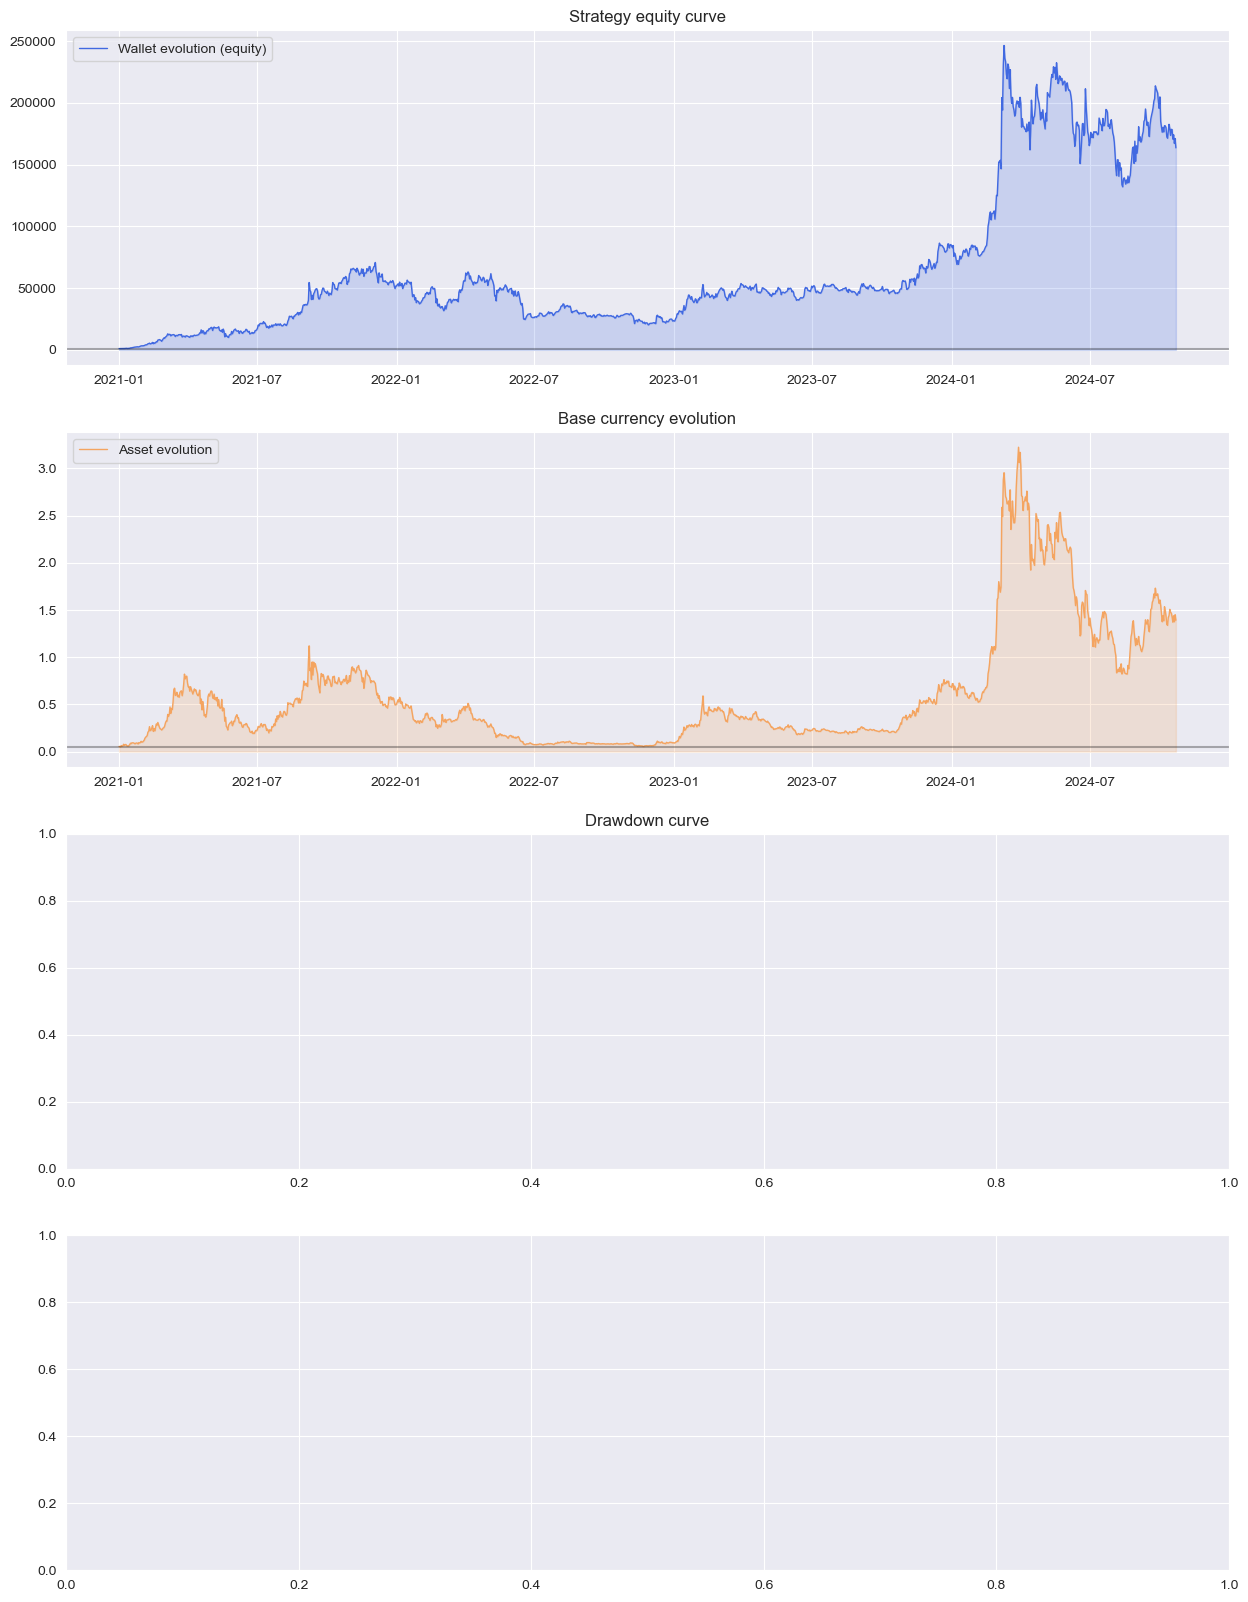

In [72]:
dt = df.copy().loc["2021":]

strat = lstm_strat(
    df = dt,
    use_short=False,
    strat=1,
)

strat.populate_indicators()
strat.populate_buy_sell(show_log=True)
bt_result = strat.run_backtest(initial_wallet=1000, return_type="metrics")
df_trades, df_days = basic_single_asset_backtest(trades=bt_result['trades'], days = bt_result['days'])
plot_wallet_vs_asset(df_days=bt_result['days'])